In [ ]:
!gdown --id 1WZVnsI-92uLbSZG-AG10PW11_8oR-R-5
!unzip AirlinePassengerSatisfaction.zip -d AirlinePassengerSatisfaction

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WZVnsI-92uLbSZG-AG10PW11_8oR-R-5
To: /content/AirlinePassengerSatisfaction.zip
100% 2.84M/2.84M [00:00<00:00, 123MB/s]
Archive:  AirlinePassengerSatisfaction.zip
replace AirlinePassengerSatisfaction/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: AirlinePassengerSatisfaction/test.csv  
  inflating: AirlinePassengerSatisfaction/train.csv  


# Install and import necessary packages

## Install packages

In [39]:
!pip install pyspark
!pip install findspark
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
seaborn 0.13.2 requires matplotlib!=3.6.1,>=3.4, which is not installed.


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Defaulting to user installation because normal site-packages is not writeable


## Import Libraries

In [33]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from pyspark.sql.functions import col, sum as spark_sum, when, collect_list, collect_set, udf, countDistinct, monotonically_increasing_id, row_number, rand
from pyspark.ml import Transformer, Pipeline
from pyspark.ml.param.shared import Param, Params, TypeConverters
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType
from pyspark import keyword_only
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer, RobustScaler, OneHotEncoder, PCA
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Set up Spark and Read data

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Initialize a Spark Session
spark = SparkSession\
    .builder\
    .appName("AirlinePassengerSatisfaction")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()

# Check if the Spark Session is active
if 'spark' in locals() and isinstance(spark, SparkSession):
    print("SparkSession is active and ready to use.")
else:
    print("SparkSession is not active. Please create a SparkSession.")

SparkSession is active and ready to use.


In [17]:
# Load train file
train = spark.read.csv(
    "Dataset/train.csv",
    header=True,
    inferSchema=True
)
# Load test file
test = spark.read.csv(
    "Dataset/test.csv",
    header=True,
    inferSchema=True
)

In [18]:
train.show(5, truncate=False)
test.show(5, truncate=False)

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|_c0|id    |Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+---------

# Airline Passenger EDA

## Define functions

In [5]:
# Function to get number rows for each column
def count_rowncol(df):
  print(type(df), "\nNumber of Rows: ", df.count(), "\nNumber of Columns: ", len(df.columns))

# Function to get null values for each column
def count_null(df):
  null_counts = df.select([
      spark_sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
      for c in df.columns
      ])
  null_counts.show(truncate=False)

# Function to get unique values for each column
def unique_values(df):
    unique_dict = {}
    for col_name in df.columns:
        unique = df.select(collect_set(col_name).alias("unique_values")).collect()
        unique_dict[col_name] = unique[0]["unique_values"]
    return unique_dict

# Sort the type of variables
def variable_type(df):
    types_list = df.dtypes
    str_variables = []
    int_variables = []
    for i in types_list:
        if i[1] == "string" and i[0]:
            str_variables.append(i[0])
        else:
            int_variables.append(i[0])
    return str_variables, int_variables

## Explore The Schema


In [6]:
# Checking numbers of rows and columns in each dataset:
print("Train dataset:")
count_rowncol(train)
print()
print("Test dataset:")
count_rowncol(test)
print()

# The typical schema of our dataset:
train.printSchema()

Train dataset:
<class 'pyspark.sql.dataframe.DataFrame'> 
Number of Rows:  103904 
Number of Columns:  25

Test dataset:
<class 'pyspark.sql.dataframe.DataFrame'> 
Number of Rows:  25976 
Number of Columns:  25

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = tru

## EDA in Pandas

In [8]:
# Load train file using pandas
pd_df = pd.read_csv(
    "Dataset/train.csv"
)

# Load test file using pandas
test_df = pd.read_csv(
    "Dataset/test.csv"
)
pd_df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Heat Map

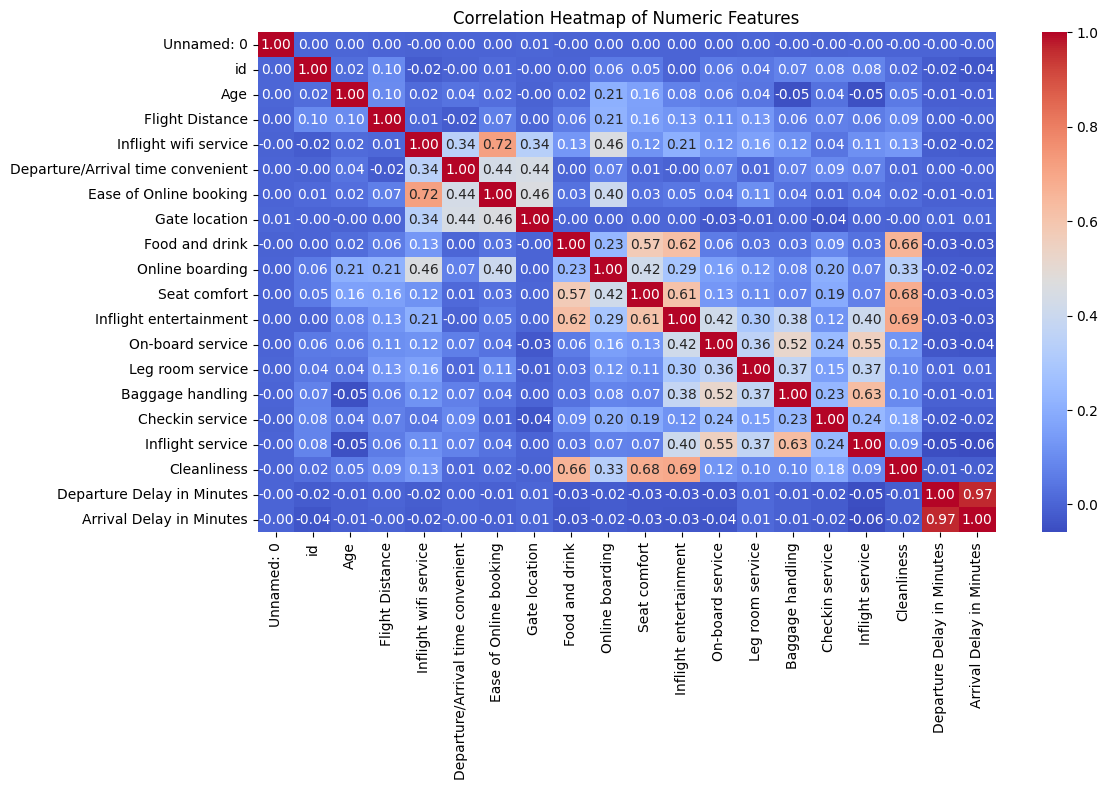

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


### Bar Chart

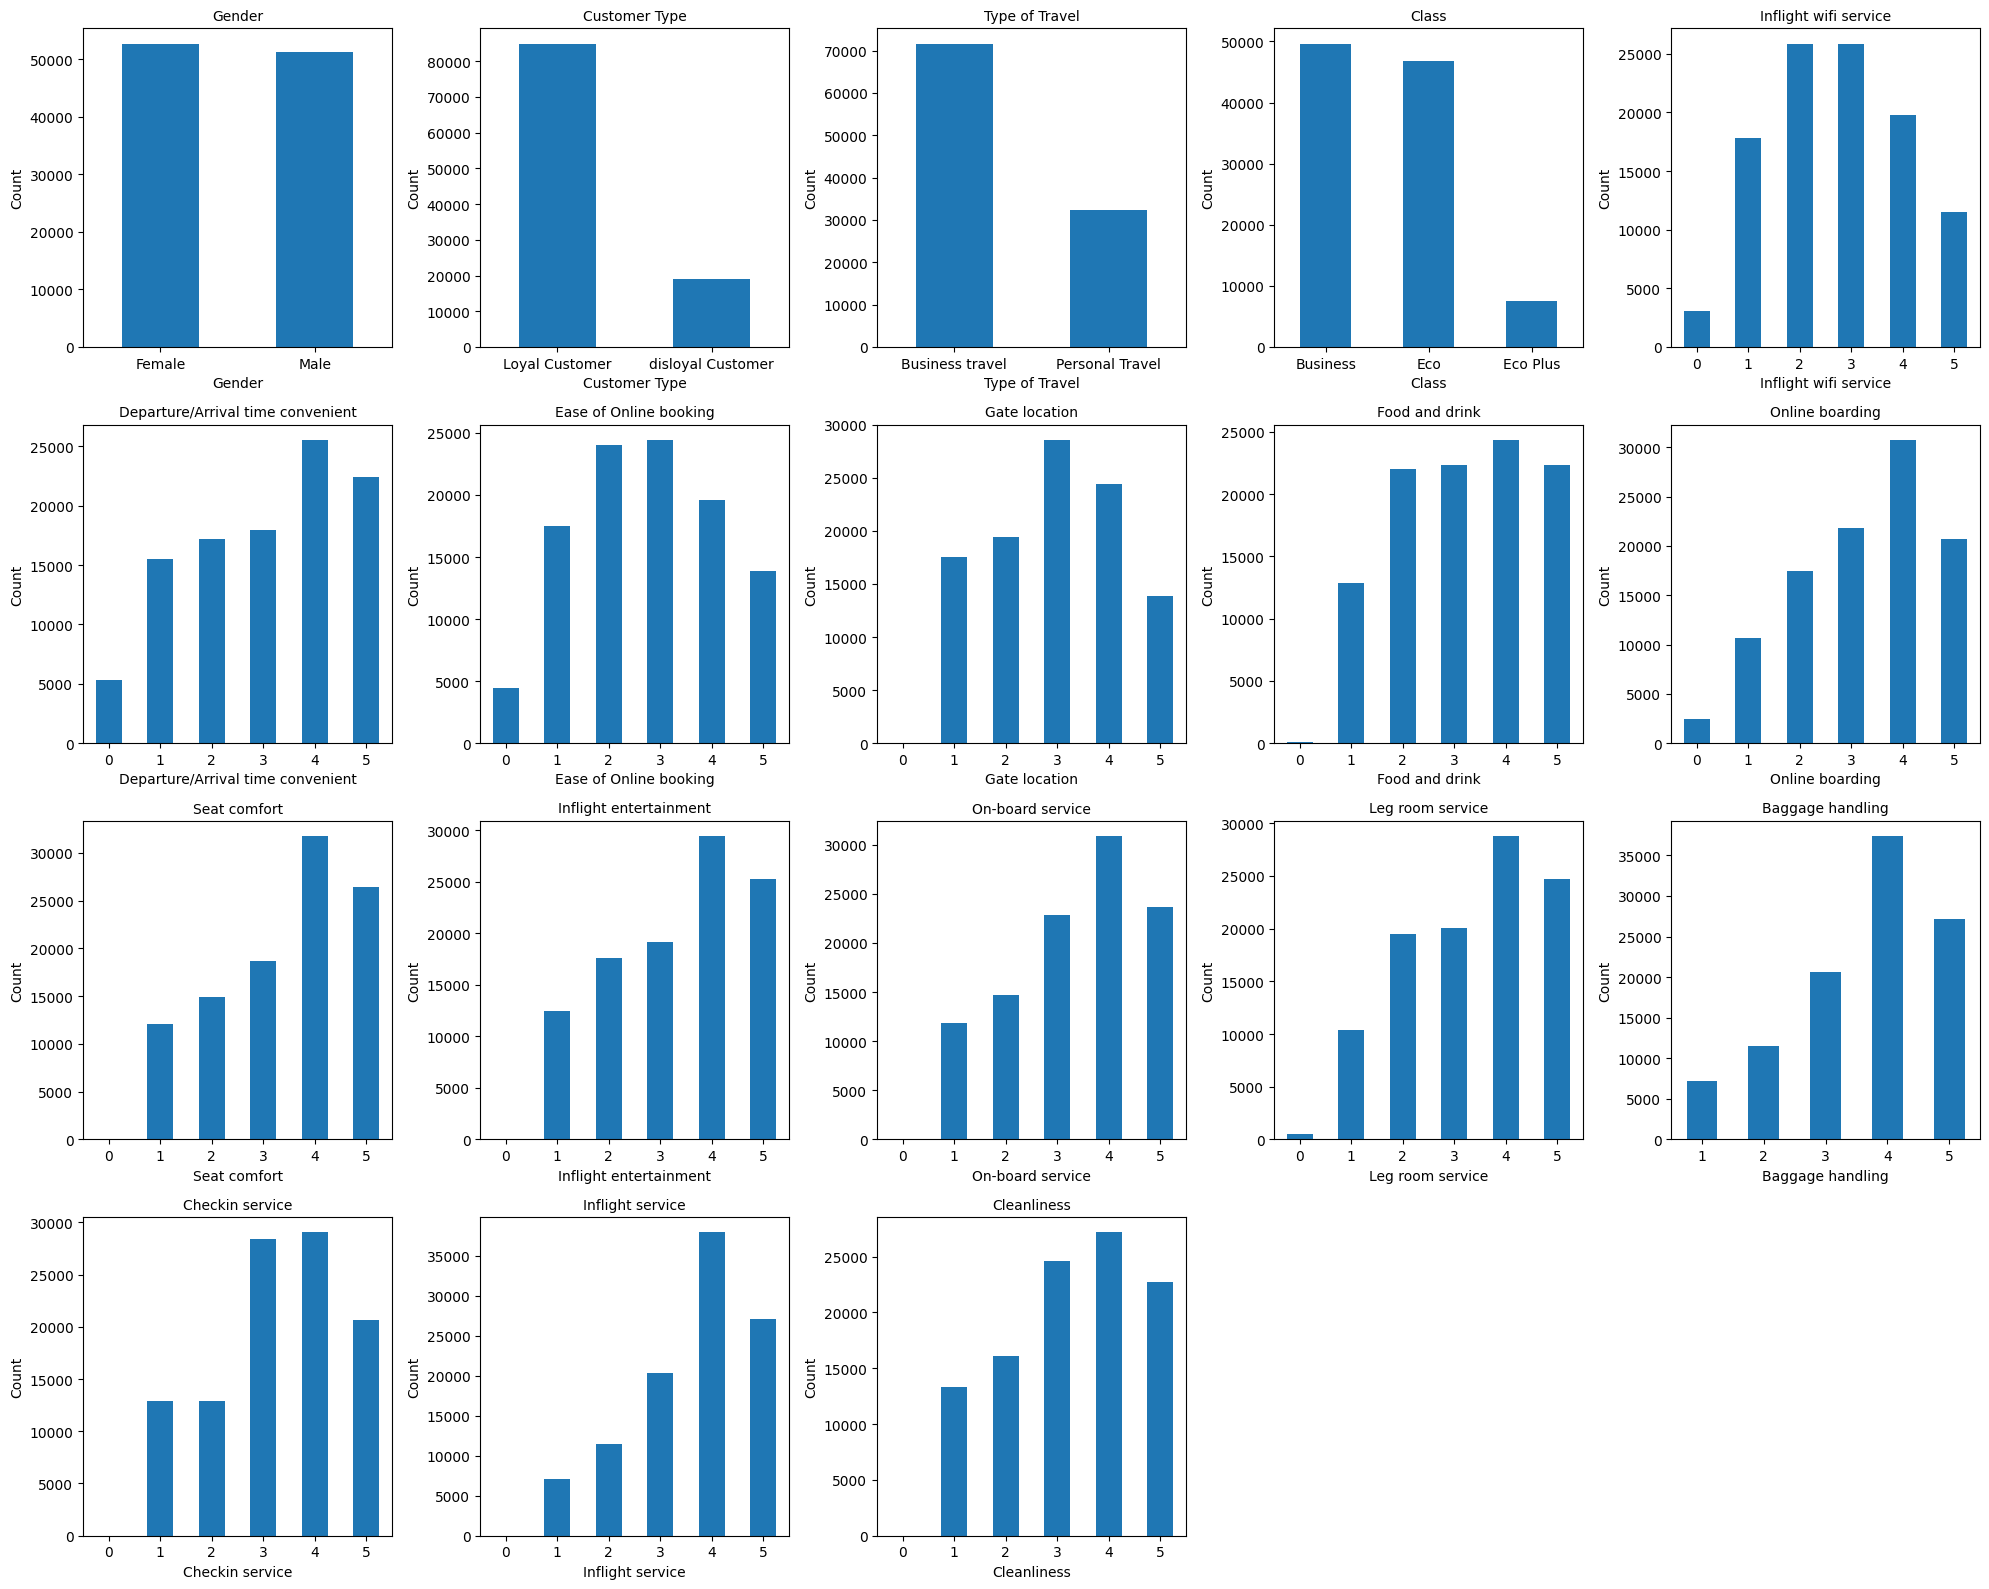

In [10]:
# Feature Selection
categorical_variables_str = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
categorical_variables_int = ['Inflight wifi service', 'Departure/Arrival time convenient',
                             'Ease of Online booking', 'Gate location', 'Food and drink',
                             'Online boarding', 'Seat comfort', 'Inflight entertainment',
                             'On-board service', 'Leg room service', 'Baggage handling',
                             'Checkin service', 'Inflight service', 'Cleanliness']

cols_to_plot = categorical_variables_str + categorical_variables_int
n_plots = len(cols_to_plot)
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))  # Adjust figsize as needed
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    value_counts = pd_df[col].value_counts(dropna=False).sort_index()
    value_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=10)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', labelrotation=0)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Pie Chart

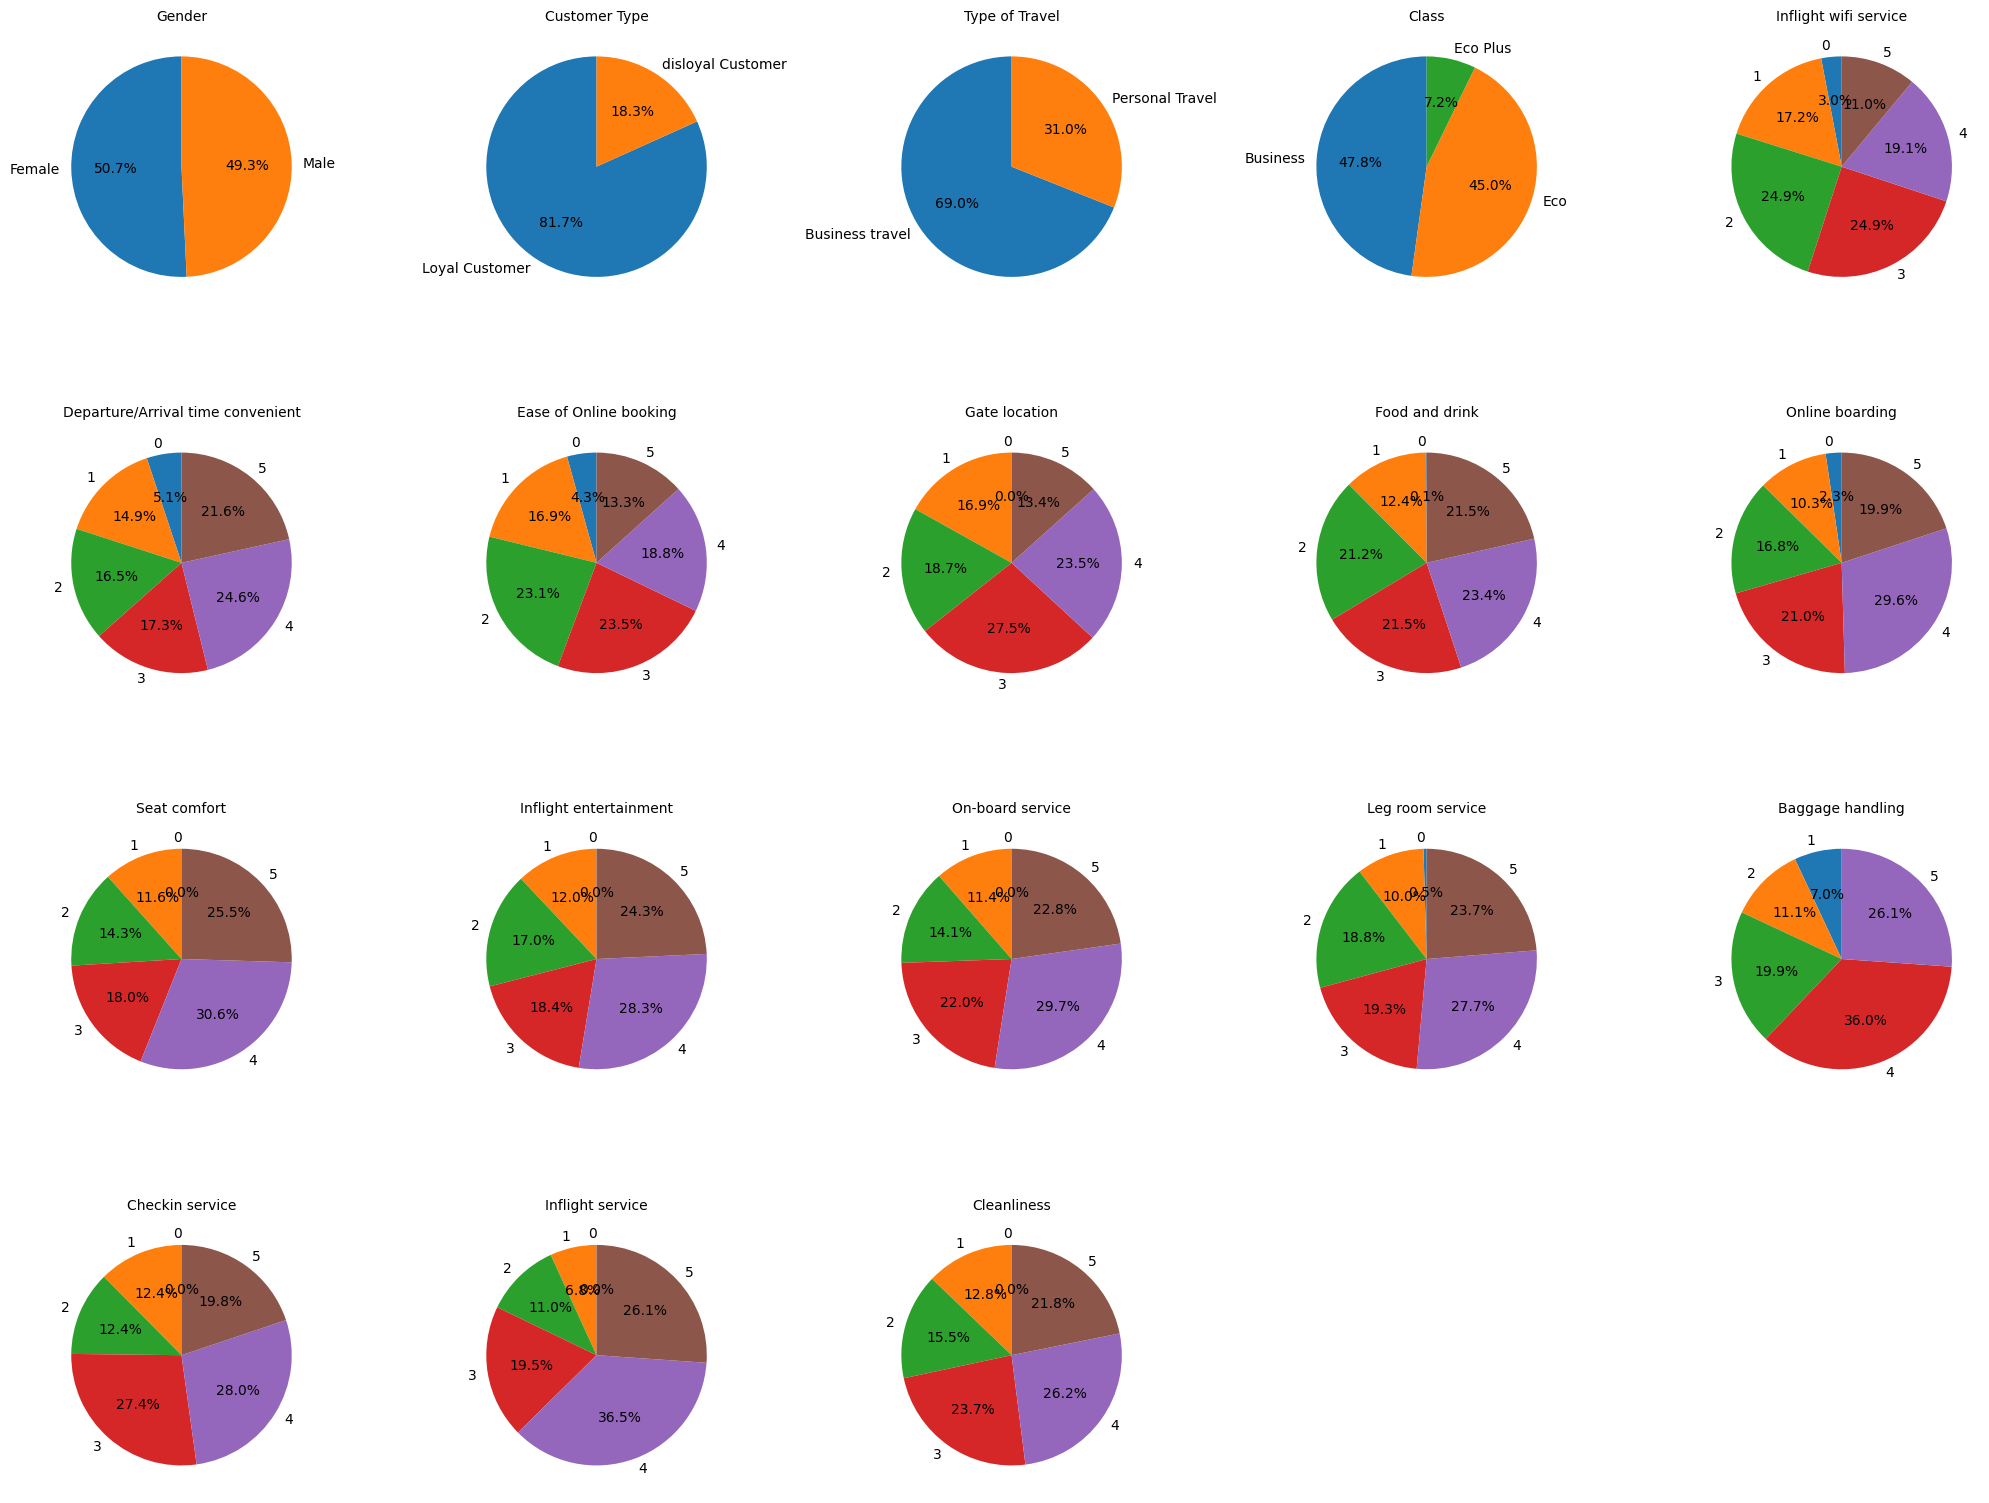

In [11]:
cols_to_plot = categorical_variables_str + categorical_variables_int
n_plots = len(cols_to_plot)
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    value_counts = pd_df[col].value_counts(dropna=False).sort_index()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"{col}", fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Some conclusions about the considered sample:
*   The sample contains a roughly equal number of male and female
passengers.

*   A significant majority of customers are returning or loyal flyers.

*   Most passengers traveled for business rather than leisure purposes.

*   Approximately half of the travelers were seated in business class.

*   Over 60% of passengers expressed satisfaction with the baggage handling service, giving it a rating of 4 or 5 out of 5.

*   More than half of the passengers found their seats to be comfortable, rating them 4 or 5 out of 5.

### Relationship Between 'Class' and 'satisfaction'

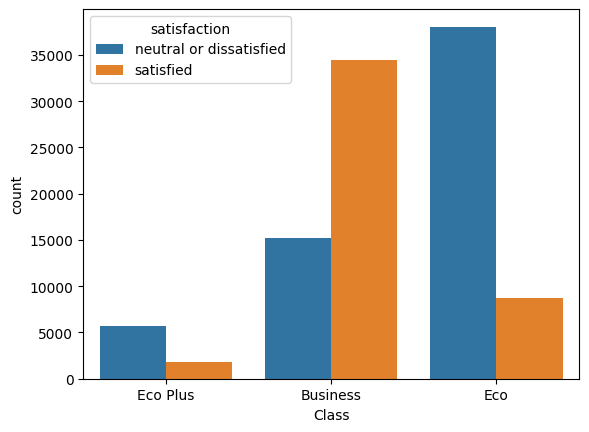

In [12]:
sns.countplot(x = 'Class', hue = 'satisfaction', data = pd_df)
plt.show()

The chart shows that most economy and economy plus passengers were dissatisfied, while business class passengers were generally satisfied.

### Age Distribution

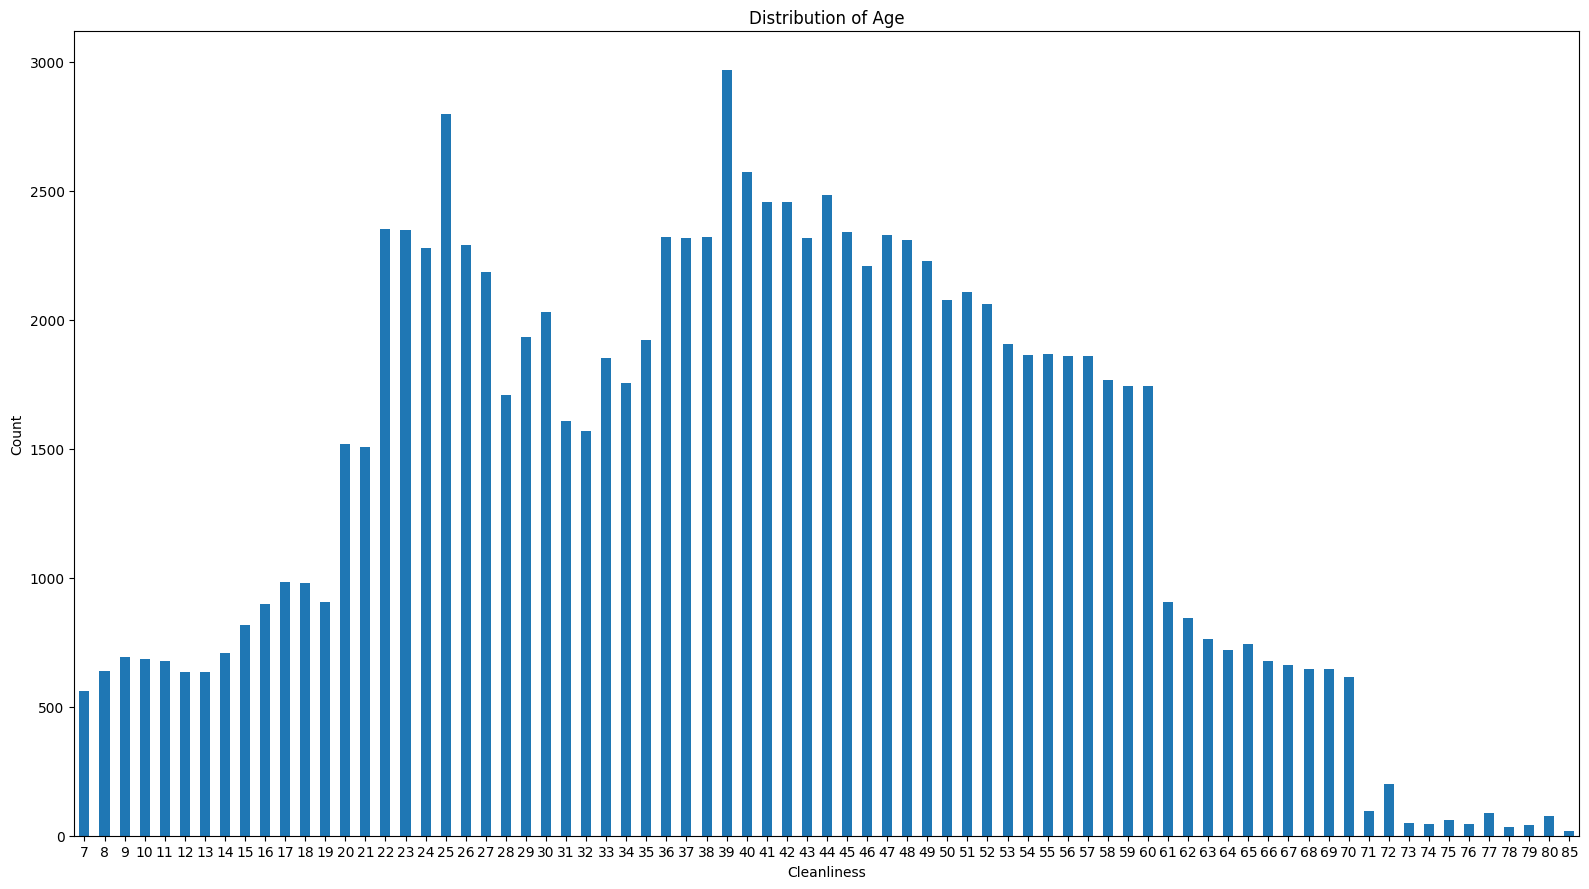

In [13]:
plt.figure(figsize=(16, 9))
value_counts = pd_df["Age"].value_counts(dropna=False).sort_index()
value_counts.plot(kind='bar')
plt.title(f"Distribution of Age")
plt.ylabel("Count")
plt.xlabel(col)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Relationship Between 'Arrival Delay in Minutes' and 'Departure Delay in Minutes'

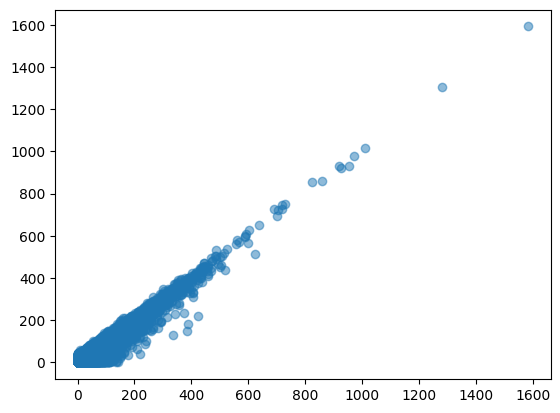

In [14]:
plt.scatter(pd_df['Arrival Delay in Minutes'], pd_df['Departure Delay in Minutes'], alpha = 0.5)

The points form a roughly straight line from lower left to upper right, suggesting a linear relationship between departure and arrival delays. This makes sense, as delays at departure typically result in similar delays at arrival unless the flight makes up time en route.


# Preprocess

## Checking Null Values

In [21]:
# Checking null values of Train dataset
print("The null values in Train dataset:")
count_null(train)

The null values in Train dataset:
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|_c0|id |Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction|
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+-

In [22]:
# Define a function to find the best imputation strategy for a column
def find_best_imputation_strategy(df, col_name, strategy_options=["mean", "median"]):
    """
    Finds the best imputation strategy (mean, median, or mode) for a given column
    by evaluating which one minimizes the standard deviation of the column after imputation.
    This is a heuristic and might not be the best strategy for all scenarios.
    """
    original_std = df.select(col_name).agg({'`{}`'.format(col_name): 'stddev'}).collect()[0][0]
    print(f"Original standard deviation of '{col_name}': {original_std}")
    best_strategy = None
    min_std_diff = float('inf')

    for strategy in strategy_options:
        imputer = Imputer(inputCols=[col_name], outputCols=[col_name], strategy=strategy)
        try:
            model = imputer.fit(df)
            df_imputed = model.transform(df)
            imputed_std = df_imputed.select(col_name).agg({'`{}`'.format(col_name): 'stddev'}).collect()[0][0]
            #print(f"Standard deviation after imputation with '{strategy}': {imputed_std}")

            if imputed_std is not None and original_std is not None:
                std_diff = abs(imputed_std - original_std)
                if std_diff < min_std_diff:
                    min_std_diff = std_diff
                    #print(f"New minimum standard deviation difference: {min_std_diff}")
                    best_strategy = strategy
        except Exception as e:
            print(f"Could not apply strategy '{strategy}' to column '{col_name}': {e}")
            continue

    return best_strategy

In [24]:
# Columns with null values identified from previous count_null output
columns_to_impute = ['Arrival Delay in Minutes']

# Impute null values in the train dataset
print("\nImputing null values in the train dataset...")
for col_name in columns_to_impute:
    best_strategy_train = find_best_imputation_strategy(train, col_name, strategy_options=["mean", "median"])
    if best_strategy_train:
        print(f"Best imputation strategy for '{col_name}' in train: {best_strategy_train}")
        imputer = Imputer(inputCols=[col_name], outputCols=[col_name], strategy=best_strategy_train)
        model = imputer.fit(train)
        train = model.transform(train)
    else:
        print(f"Could not find a suitable strategy for '{col_name}' in train.")

print("\nChecking null values of Train dataset after imputation:")
count_null(train)
# Checking description of Train dataset
print("The description of Train dataset:") 
train.describe().show(truncate=False)


Imputing null values in the train dataset...
Original standard deviation of 'Arrival Delay in Minutes': 38.649776132024144
Best imputation strategy for 'Arrival Delay in Minutes' in train: mean

Checking null values of Train dataset after imputation:
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|_c0|id |Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|A

## Checking Outliers

In [25]:
# Function to detect and replace outliers with the mean using IQR
def check_outlier(df, col_name):
    print(f"\nProcessing column: {col_name}")
    # Calculate Q1, Q3, and IQR
    quartiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quartiles[0]
    Q3 = quartiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"  Lower Bound (IQR method): {lower_bound}")
    print(f"  Upper Bound (IQR method): {upper_bound}")

    # Identify outliers
    is_outlier_col = (col(col_name) < lower_bound) | (col(col_name) > upper_bound)
    outliers_count = df.filter(is_outlier_col).count()
    total_count = df.count()
    print(f"  Number of outliers detected: {outliers_count} ({outliers_count/total_count:.2%})")

    return df

In [26]:
numeric_columns_for_outlier_check = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
categorical_variables_str = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
                             'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
                             'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service',
                             'Cleanliness']

total_column = numeric_columns_for_outlier_check + categorical_variables_str

# Apply outlier replacement to the selected numerical columns in the training data
for col_name in total_column:
    train = check_outlier(train, col_name)


Processing column: Age
  Q1: 27.0, Q3: 49.0, IQR: 22.0
  Lower Bound (IQR method): -6.0
  Upper Bound (IQR method): 82.0
  Number of outliers detected: 17 (0.02%)

Processing column: Flight Distance
  Q1: 424.0, Q3: 1587.0, IQR: 1163.0
  Lower Bound (IQR method): -1320.5
  Upper Bound (IQR method): 3331.5
  Number of outliers detected: 5615 (5.40%)

Processing column: Departure Delay in Minutes
  Q1: 0.0, Q3: 9.0, IQR: 9.0
  Lower Bound (IQR method): -13.5
  Upper Bound (IQR method): 22.5
  Number of outliers detected: 18381 (17.69%)

Processing column: Arrival Delay in Minutes
  Q1: 0.0, Q3: 10.0, IQR: 10.0
  Lower Bound (IQR method): -15.0
  Upper Bound (IQR method): 25.0
  Number of outliers detected: 16994 (16.36%)

Processing column: Inflight wifi service
  Q1: 2.0, Q3: 4.0, IQR: 2.0
  Lower Bound (IQR method): -1.0
  Upper Bound (IQR method): 7.0
  Number of outliers detected: 0 (0.00%)

Processing column: Departure/Arrival time convenient
  Q1: 2.0, Q3: 4.0, IQR: 2.0
  Lower Bo

## Build pipeline

In [27]:
class ScaledFeatureExpander(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    @keyword_only
    def __init__(self, inputCols=None, outputPrefix="_scaled"):
        super(ScaledFeatureExpander, self).__init__()
        self.inputCols = inputCols
        self.outputPrefix = outputPrefix

    def _transform(self, df):
        # Step 1: Assemble
        assembler = VectorAssembler(inputCols=self.inputCols, outputCol="numeric_features")
        df = assembler.transform(df)

        # Step 2: Robust Scale
        scaler = RobustScaler(
            inputCol="numeric_features",
            outputCol="scaled_features",
        )
        scaler_model = scaler.fit(df)
        df = scaler_model.transform(df)

        # Step 3: Unpack
        def unpack_vector(v):
            return v.toArray().tolist() if v is not None else [None]*len(self.inputCols)

        unpack_udf = udf(unpack_vector, ArrayType(FloatType()))
        df = df.withColumn("scaled_array", unpack_udf(col("scaled_features")))

        output_cols = [col_name + self.outputPrefix for col_name in self.inputCols]
        for i, col_name in enumerate(self.inputCols):
            df = df.withColumn(col_name + self.outputPrefix, col("scaled_array").getItem(i))

        # Clean up intermediate columns
        return df.drop("numeric_features", "scaled_features", "scaled_array", *numeric_variables)


In [28]:
df = train

# Drop columns id and numbers
columns_to_drop = ['_c0', 'id']
df = df.drop(*columns_to_drop)

# Displaying basic statistics
df.describe().show(truncate=False)

# Checking Distinct values in train dataset
print("Distinct values check: ")
df.select([countDistinct(c) for c in df.columns]).show()

#Checking unique values
unique_values_dict = unique_values(df)
for column, values in unique_values_dict.items():
    print(f"Column: {column}, Unique Values: {values}")

# Show dataframe
df.show(5, truncate=False)

+-------+------+-----------------+------------------+---------------+--------+------------------+---------------------+---------------------------------+----------------------+------------------+------------------+------------------+------------------+----------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------------------------+------------------------+-----------------------+
|summary|Gender|Customer Type    |Age               |Type of Travel |Class   |Flight Distance   |Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location     |Food and drink    |Online boarding   |Seat comfort      |Inflight entertainment|On-board service  |Leg room service  |Baggage handling  |Checkin service  |Inflight service  |Cleanliness       |Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+-------+------+-----------------+------------------+---------------+-

In [29]:
# Feature Selection
target_variable = ["satisfaction"]
numeric_variables = ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]
categorical_variables_str = [col for col in variable_type(df)[0] if col != "satisfaction"]
categorical_variables_int = [
    c for c in df.columns
        if c not in numeric_variables + categorical_variables_str + ["_c0", "id"] and c != "satisfaction"
]

print("Categorical variables in int: ", categorical_variables_int)
print("Categorical variables in str: ", categorical_variables_str)
print("Numeric variables: ", numeric_variables)
print("Target variable: ", target_variable)

Categorical variables in int:  ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
Categorical variables in str:  ['Gender', 'Customer Type', 'Type of Travel', 'Class']
Numeric variables:  ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Target variable:  ['satisfaction']


In [30]:
#Feature Engineering:
# 0.Handle Missing Values
imputer = Imputer(
    inputCols=["Arrival Delay in Minutes"],
    outputCols=["Arrival Delay in Minutes"],
    strategy="median"
    )

# 1.Stage String Indexer and One Hot Encoder for the binary features:
str_indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
    for col in categorical_variables_str
]
str_encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_variables_str],
    outputCols=[f"{col}_encoded" for col in categorical_variables_str],
    dropLast=True
)

# 2. Stage Scale the feature (numeric columns) with RobustScaler
scaler_stage = ScaledFeatureExpander(
    inputCols=numeric_variables,
    outputPrefix="_scaled"
)

# 3. Stage vectorize the numeric variables (numeric columns and categorical int columns) into Feature
assembler = VectorAssembler(inputCols= categorical_variables_int + [f"{col}_scaled" for col in numeric_variables],
                            outputCol="features"
                            )

# 4. Create PCA:
# pca = PCA(inputCol="features", outputCol="pca_features", k=10)

# 5. StringIndexer for target variable
target_indexer = StringIndexer(
    inputCol="satisfaction",
    outputCol="label",
    handleInvalid="keep"
)

# Create Pipeline
pipeline= Pipeline(stages=[target_indexer,
                           imputer,
                           *str_indexers,# Unpack list of indexers
                           str_encoder,
                           scaler_stage,
                           assembler
                            ]
                        )

In [38]:
# Dataframe Processed
df_processed = pipeline.fit(df) # Fit pipeline on original train data

# Transform both train and test original dataframes
train_processed = df_processed.transform(train)

# Select the features and label column for the LR model
train_final = train_processed.select("features", col("label").cast(DoubleType()).alias("label"))

# Show
train_final.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                             |label|
+-------------------------------------------------------------------------------------------------------------------------------------+-----+
|[3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,0.5416666865348816,0.34716981649398804,2.0833332538604736,1.384615421295166]|0.0  |
|[3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0416666269302368,0.1773584932088852,0.0833333358168602,0.4615384638309479]|0.0  |
|[2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,1.0833333730697632,0.8618867993354797,0.0,0.0]                              |1.0  |
|[2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,1.0416666269302368,0.4241509437561035,0.9166666865348816,0.692307710647583] |0.0  |
|[3.0,

# Build Model

In [40]:
# Split train,test from the processed train dataset
train_data, test_data = train_final.randomSplit([0.8, 0.2], seed=42)

### Logistics Regression with PCA


In [ ]:
# Initialize Binary Logistic Regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",  # Binary target (0 or 1)
    maxIter=500,
    regParam=0.001,
    elasticNetParam=1.0,    # L2 regularization
    family="binomial"       # Default for binary classification
)

''' LR model without Fine-tune '''
# 1. Determine input feature size
input_size = len(train_final.select("features").first()[0])

# 2. Train model
lr_model = lr.fit(train_data)

# 3. Predict on test data and show
predictions = lr_model.transform(test_data)
predictions.select("label", "prediction", "probability").show(10, truncate=False)

# 4. Evaluate using Binary evaluator (e.g., AUC)
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",  # or "probability"
    metricName="areaUnderROC"          # or "areaUnderPR"
)

auc = evaluator.evaluate(predictions)
print(f"LR AUC: {auc:.4f}")

''' LR model after Fine-tune '''
# 1. Define hyperparameter grid
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # L2, elastic, L1
    .build()
)

# 2. Define binary evaluator (e.g., AUC-ROC)
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",  # or "probability"
    metricName="areaUnderROC"          # or "areaUnderPR"
)

# 3. Set up cross-validator
cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=10,
    parallelism=10,
    seed=42
)

# 6. Train the cross-validated model
lr_cv_model = cv.fit(train_data)

# 7. Predict on test set
lr_cv_predictions = lr_cv_model.transform(test_data)

# 8. Evaluate tuned model
auc = evaluator.evaluate(lr_cv_predictions)
print(f"Tuned LR AUC: {auc:.4f}")

# 10. Save full streamlit pipeline model
lr_cv_model.write().overwrite().save("/content/models/Tuned_LR_PCA")

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|1.0  |0.0       |[0.9823193852178109,0.017680614782189075]|
|1.0  |0.0       |[0.9905154597570294,0.00948454024297063] |
|1.0  |0.0       |[0.9830088271990014,0.0169911728009986]  |
|1.0  |0.0       |[0.9776962904647392,0.02230370953526084] |
|1.0  |0.0       |[0.9803479200640421,0.019652079935957856]|
|1.0  |0.0       |[0.9833605973937842,0.01663940260621577] |
|1.0  |0.0       |[0.9697496901609718,0.03025030983902821] |
|1.0  |0.0       |[0.9574512652223154,0.042548734777684616]|
|1.0  |0.0       |[0.9213383102067311,0.07866168979326893] |
|1.0  |0.0       |[0.9886888665658536,0.011311133434146359]|
+-----+----------+-----------------------------------------+
only showing top 10 rows

LR AUC: 0.8913
Tuned LR AUC: 0.8913


In [ ]:
# Show MLP sample predictions
lr_cv_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.6868028048383717,0.31319719516162825]|
|0.0  |0.0       |[0.6647661893885219,0.33523381061147806]|
|0.0  |1.0       |[0.4533496510835122,0.5466503489164878] |
|0.0  |0.0       |[0.9268712860494346,0.07312871395056542]|
|1.0  |1.0       |[0.3056915718976209,0.694308428102379]  |
|1.0  |1.0       |[0.19860118314193148,0.8013988168580686]|
|0.0  |0.0       |[0.9102116788477463,0.08978832115225366]|
|1.0  |0.0       |[0.7728821191377002,0.22711788086229978]|
|1.0  |1.0       |[0.07163620443367193,0.9283637955663281]|
|0.0  |1.0       |[0.43888767035571075,0.5611123296442893]|
+-----+----------+----------------------------------------+
only showing top 10 rows



In [ ]:
test_proess = pipeline.fit(test).transform(test)
test_final = test_proess.select("features", col("label").cast(DoubleType()).alias("label"))
test_final.show(5, truncate=False)

lr_cv_predictions = lr_cv_model.transform(test_final)
lr_cv_predictions.select("label", "prediction", "probability").show(10, truncate=False)
auc = evaluator.evaluate(lr_cv_predictions)
print(f"Tuned LR AUC: {auc:.4f}")


+------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                            |label|
+------------------------------------------------------------------------------------------------------------------------------------+-----+
|[5.0,4.0,3.0,4.0,3.0,4.0,3.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,2.1666667461395264,0.12030075490474701,4.166666507720947,3.384615421295166]|1.0  |
|[1.0,1.0,3.0,1.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,1.5,2.1526315212249756,0.0,0.0]                                            |1.0  |
|[2.0,0.0,2.0,4.0,2.0,2.0,2.0,2.0,4.0,1.0,3.0,2.0,2.0,2.0,0.8333333134651184,0.14436089992523193,0.0,0.0]                            |0.0  |
|[0.0,0.0,0.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,1.8333333730697632,2.539097785949707,0.0,0.4615384638309479]               |1.0  |
|[2.0,3.0,4.0

### MultiLayer Perceptron


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define MLP
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    maxIter=200,
    seed=123
)

# Define input size
input_size = len(train_final.select("features").first()[0])

# Define a hyperparameter grid (vary hidden layers)
paramGrid_mlp = ParamGridBuilder()\
    .addGrid(mlp.layers, [
        [input_size, 16, 2],
        [input_size, 32, 16, 2],
        [input_size, 64, 32, 2]
    ])\
    .build()

# Reuse evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# CrossValidator
cv_mlp = CrossValidator(
    estimator=mlp,
    estimatorParamMaps=paramGrid_mlp,
    evaluator=evaluator,
    numFolds=10,
    parallelism=10,
    seed=42
)

# Train tuned MLP model
cv_mlp_model = cv_mlp.fit(train_data)

# Predict and evaluate
mlp_cv_predictions = cv_mlp_model.transform(test_data)
mlp_cv_auc = evaluator.evaluate(mlp_cv_predictions)
print(f"Tuned MLP AUC: {mlp_cv_auc:.4f}")

# Save model
cv_mlp_model.write().overwrite().save("/content/models/Tuned_MLP_PCA")


In [ ]:
mlp_cv_predictions = cv_mlp_model.transform(test_final)
mlp_cv_predictions.select("label", "prediction", "probability").show(10, truncate=False)
auc = evaluator.evaluate(mlp_cv_predictions)
print(f"Tuned LR AUC: {auc:.4f}")

In [ ]:
# Show MLP sample predictions
mlp_cv_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

### RandomForest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    seed=42
)

# Parameter grid for tuning
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.numTrees, [50, 100])\
    .addGrid(rf.maxDepth, [5, 8, 12])\
    .build()

# CrossValidator
cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=10,
    parallelism=10,
    seed=42
)

# Train tuned RF model
cv_rf_model = cv_rf.fit(train_data)

# Predict and evaluate
rf_cv_predictions = cv_rf_model.transform(test_data)
rf_cv_auc = evaluator.evaluate(rf_cv_predictions)
print(f"Tuned Random Forest AUC: {rf_cv_auc:.4f}")

# Save model
cv_rf_model.write().overwrite().save("/content/models/Tuned_RF_PCA")


In [ ]:
rf_cv_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

In [ ]:
rf_cv_predictions = cv_rf_model.transform(test_final)
rf_cv_predictions.select("label", "prediction", "probability").show(10, truncate=False)
auc = evaluator.evaluate(rf_cv_predictions)
print(f"Tuned RF AUC: {auc:.4f}")

### Gradient Boost Tree

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(
    featuresCol="features",
    labelCol="label",
    seed=42
)

# Parameter grid for tuning
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxIter, [10, 20])\
    .addGrid(gbt.maxDepth, [4, 6])\
    .build()

# Reuse evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# CrossValidator
cv_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator,
    numFolds=10,
    parallelism=10,
    seed=42
)

# Train tuned GBT model
cv_gbt_model = cv_gbt.fit(train_data)

# Predict and evaluate
gbt_cv_predictions = cv_gbt_model.transform(test_data)
gbt_cv_auc = evaluator.evaluate(gbt_cv_predictions)
print(f"Tuned Gradient Boosting Tree AUC: {gbt_cv_auc:.4f}")

# Save model
cv_gbt_model.write().overwrite().save("/content/models/Tuned_GBT_PCA")

# Show GBT sample predictions
gbt_cv_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

# Evaluate on the held-out test data
gbt_cv_predictions_test_final = cv_gbt_model.transform(test_final)
gbt_cv_predictions_test_final.select("label", "prediction", "probability").show(10, truncate=False)
auc_test_final = evaluator.evaluate(gbt_cv_predictions_test_final)
print(f"Tuned GBT AUC on test_final: {auc_test_final:.4f}")

Tuned Gradient Boosting Tree AUC: 0.9777
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.6201893434903047,0.37981065650969525]|
|0.0  |0.0       |[0.9148606146837546,0.08513938531624543]|
|0.0  |0.0       |[0.6066296504686169,0.39337034953138306]|
|0.0  |0.0       |[0.956398872623485,0.043601127376515]   |
|1.0  |1.0       |[0.05498202940730468,0.9450179705926953]|
|1.0  |1.0       |[0.09085192348748267,0.9091480765125173]|
|0.0  |0.0       |[0.9222494545495725,0.07775054545042748]|
|1.0  |1.0       |[0.08772309384831467,0.9122769061516853]|
|1.0  |1.0       |[0.040163967020397026,0.959836032979603]|
|0.0  |0.0       |[0.9564346263743586,0.04356537362564139]|
+-----+----------+----------------------------------------+
only showing top 10 rows

+-----+----------+-----------------------------------------+
|label|prediction|probability   

### Monitor Overfitting/Underfitting:



Evaluating Tuned Logistic Regression on train and test data...
Tuned Logistic Regression Train areaUnderROC: 0.8868
Tuned Logistic Regression Test areaUnderROC: 0.8913


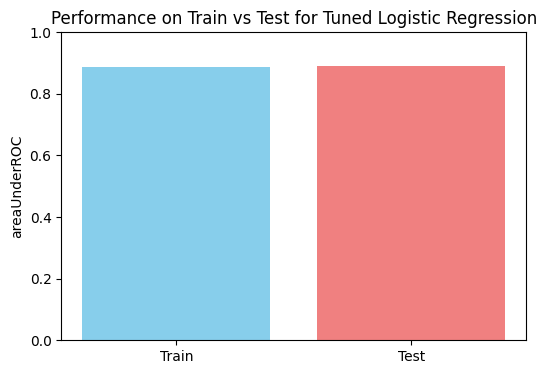


Evaluating Tuned MultiLayer Perceptron on train and test data...
Tuned MultiLayer Perceptron Train areaUnderROC: 0.9807
Tuned MultiLayer Perceptron Test areaUnderROC: 0.9795


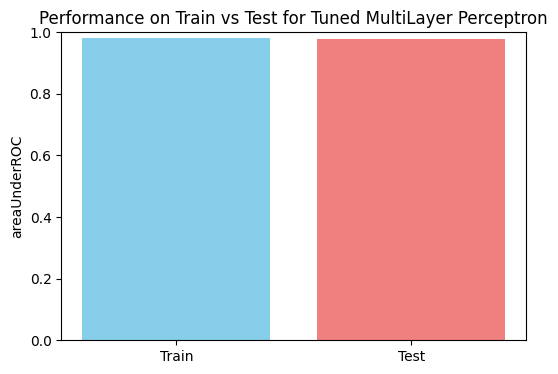


Evaluating Tuned Random Forest on train and test data...
Tuned Random Forest Train areaUnderROC: 0.9908
Tuned Random Forest Test areaUnderROC: 0.9867


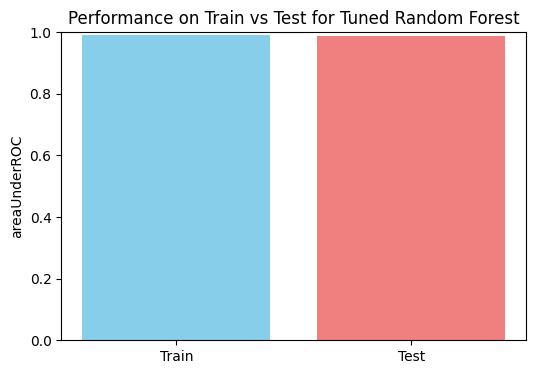


Evaluating Tuned Gradient Boosting Tree on train and test data...
Tuned Gradient Boosting Tree Train areaUnderROC: 0.9780
Tuned Gradient Boosting Tree Test areaUnderROC: 0.9777


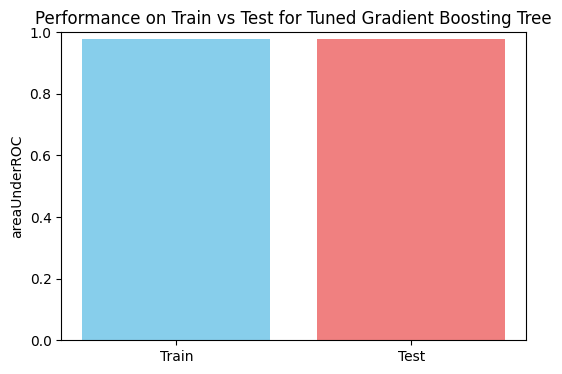

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, RandomForestClassifier, GBTClassifier

# Assuming you have already trained your models (lr_cv_model, cv_mlp_model, cv_rf_model, cv_gbt_model)
# and have the train_data and test_data DataFrames ready.

def plot_learning_curve_single_model(model, train_df, test_df, evaluator, model_name="Model"):
    """
    Plots a simplified learning curve by evaluating a model on training and testing data.
    This is a basic visualization and not a true learning curve which requires training
    on varying subsets of data sizes.

    Args:
        model: Trained Spark MLlib model.
        train_df: Training DataFrame.
        test_df: Testing DataFrame.
        evaluator: Spark MLlib evaluator (e.g., BinaryClassificationEvaluator).
        model_name: Name of the model for the plot title.
    """
    print(f"\nEvaluating {model_name} on train and test data...")

    # Evaluate on training data
    train_predictions = model.transform(train_df)
    train_metric = evaluator.evaluate(train_predictions)
    print(f"{model_name} Train {evaluator.getMetricName()}: {train_metric:.4f}")

    # Evaluate on testing data
    test_predictions = model.transform(test_df)
    test_metric = evaluator.evaluate(test_predictions)
    print(f"{model_name} Test {evaluator.getMetricName()}: {test_metric:.4f}")

    # Plotting (simplified)
    labels = ['Train', 'Test']
    metrics = [train_metric, test_metric]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, metrics, color=['skyblue', 'lightcoral'])
    plt.ylabel(evaluator.getMetricName())
    plt.title(f'Performance on Train vs Test for {model_name}')
    plt.ylim(0, 1) # Assuming AUC or similar metric
    plt.show()

# Plot learning curves for each trained model
plot_learning_curve_single_model(lr_cv_model, train_data, test_data, evaluator, model_name="Tuned Logistic Regression")
plot_learning_curve_single_model(cv_mlp_model, train_data, test_data, evaluator, model_name="Tuned MultiLayer Perceptron")
plot_learning_curve_single_model(cv_rf_model, train_data, test_data, evaluator, model_name="Tuned Random Forest")
plot_learning_curve_single_model(cv_gbt_model, train_data, test_data, evaluator, model_name="Tuned Gradient Boosting Tree")


# Build App

In [ ]:
# Download lib streamlit
!pip install streamlit plotly -q # Added plotly dependency

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


### Old Version

In [ ]:
%%writefile app.py
# Streamlit app: Upload CSV and apply Spark pipeline for prediction
import streamlit as st
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer, StringIndexer, RobustScaler, OneHotEncoder, PCA
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, FloatType, ArrayType, StringType
from pyspark.ml.pipeline import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import Param, Params
from pyspark.ml.linalg import DenseVector

# Start Spark
spark = SparkSession.builder.appName("CSV Prediction").getOrCreate()

# === Custom Transformers ===
class ScaledFeatureExpander(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None, outputPrefix="_scaled"):
        super(ScaledFeatureExpander, self).__init__()
        self.inputCols = inputCols
        self.outputPrefix = outputPrefix

    def _transform(self, df):
        # Step 1: Assemble
        assembler = VectorAssembler(inputCols=self.inputCols, outputCol="numeric_features")
        df = assembler.transform(df)

        # Step 2: Robust Scale
        scaler = RobustScaler(
            inputCol="numeric_features",
            outputCol="scaled_features",
        )
        scaler_model = scaler.fit(df)
        df = scaler_model.transform(df)

        # Step 3: Unpack
        def unpack_vector(v):
            return v.toArray().tolist() if v is not None else [None]*len(self.inputCols)

        unpack_udf = udf(unpack_vector, ArrayType(FloatType()))
        df = df.withColumn("scaled_array", unpack_udf(col("scaled_features")))

        output_cols = [col_name + self.outputPrefix for col_name in self.inputCols]
        for i, col_name in enumerate(self.inputCols):
            df = df.withColumn(col_name + self.outputPrefix, col("scaled_array").getItem(i))

        # Clean up intermediate columns
        return df.drop("numeric_features", "scaled_features", "scaled_array", *numeric_variables)

# === App UI ===
st.title("🛬 Predict Airline Satisfaction")

uploaded_file = st.file_uploader("Upload a CSV file", type="csv")

if uploaded_file is not None:
    pd_df = pd.read_csv(uploaded_file)
    spark_df = spark.createDataFrame(pd_df)

    for col_name in ["_c0", "id"]:
        if col_name in spark_df.columns:
            spark_df = spark_df.drop(col_name)

    numeric_variables = [
        "Age", "Flight Distance",
        "Departure Delay in Minutes", "Arrival Delay in Minutes"
    ]

    categorical_variables_int = [
        'Inflight wifi service', 'Departure/Arrival time convenient',
        'Ease of Online booking', 'Gate location', 'Food and drink',
        'Online boarding', 'Seat comfort', 'Inflight entertainment',
        'On-board service', 'Leg room service', 'Baggage handling',
        'Checkin service', 'Inflight service', 'Cleanliness'
    ]

    categorical_variables_str = [
        "Gender", "Customer Type", "Type of Travel", "Class"
    ]
    target_variable = "satisfaction"

    #Feature Engineering:
    # 0.Handle Missing Values
    imputer = Imputer(
        inputCols=["Arrival Delay in Minutes"],
        outputCols=["Arrival Delay in Minutes"],
        strategy="median"
        )

    # 1.Stage String Indexer and One Hot Encoder for the binary features:
    str_indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
        for col in categorical_variables_str
    ]
    str_encoder = OneHotEncoder(
        inputCols=[f"{col}_index" for col in categorical_variables_str],
        outputCols=[f"{col}_encoded" for col in categorical_variables_str],
        dropLast=True
    )

    # 2. Stage Scale the feature (numeric columns) with RobustScaler
    scaler_stage = ScaledFeatureExpander(
        inputCols=numeric_variables,
        outputPrefix="_scaled"
    )

    # 3. Stage vectorize the numeric variables (numeric columns and categorical int columns) into Feature
    assembler = VectorAssembler(inputCols= categorical_variables_int + [f"{col}_scaled" for col in numeric_variables],
                                outputCol="features"
                                )

    # 4. Create PCA:
    # pca = PCA(inputCol="features", outputCol="pca_features", k=10)

    # 5. StringIndexer for target variable
    target_indexer = StringIndexer(
        inputCol="satisfaction",
        outputCol="label",
        handleInvalid="keep"
    )

    # Create Pipeline
    pipeline= Pipeline(stages=[target_indexer,
                            imputer,
                            *str_indexers,# Unpack list of indexers
                            str_encoder,
                            scaler_stage,
                            assembler
                                ]
                            )

    pipeline_model = pipeline.fit(spark_df)
    processed_df = pipeline_model.transform(spark_df)

    model = CrossValidatorModel.load("/content/models/Tuned_RF_PCA")
    predictions = model.transform(processed_df).select("label", "prediction", "probability")

    st.success("✅ Predictions generated!")

    @udf(ArrayType(StringType()))
    def round_probability(vec):
        if vec is not None:
            return [f"{float(x):.3f}" for x in vec]
        return None

    predictions = predictions.withColumn("probability_rounded", round_probability(col("probability")))
    df_clean = predictions.drop("probability").withColumnRenamed("probability_rounded", "probability")

    df_pd = df_clean.toPandas()
    st.dataframe(df_pd)

    st.title("Pie Chart Of Prediction Accuracy")

    import matplotlib.pyplot as plt

    # Calculate correct vs incorrect predictions
    df_pd["correct"] = df_pd["label"] == df_pd["prediction"]
    correct_count = df_pd["correct"].sum()
    incorrect_count = len(df_pd) - correct_count

    # Prepare pie chart
    labels = ['Correct', 'Incorrect']
    sizes = [correct_count, incorrect_count]
    colors = ['#1f77b4', '#ff7f0e']
    explode = (0.05, 0)  # explode first slice (Correct)

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    st.pyplot(fig)

    csv = df_pd.to_csv(index=False).encode("utf-8")
    st.download_button("📥 Download Results", data=csv, file_name="predictions.csv", mime="text/csv")


Overwriting app.py


### New Version

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.feature import VectorAssembler
from datetime import datetime
import json

# Initialize Spark session
spark = SparkSession.builder \
    .appName("AirlinePassengerSatisfaction") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Page configuration
st.set_page_config(
    page_title="Airline Satisfaction Predictor",
    page_icon="✈️",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS styling with lighter colors
st.markdown(r"""
<style>
    :root {
        --primary: #3B82F6;
        --secondary: #6366F1;
        --accent: #10B981;
        --background: linear-gradient(135deg, #F8FAFC 0%, #E2E8F0 100%);
        --card-bg: rgba(255, 255, 255, 0.9);
    }

    .stApp {
        background: var(--background) !important;
        color: #1E293B !important;
        font-family: 'Poppins', sans-serif !important;
    }

    .main-container {
        background: var(--card-bg) !important;
        backdrop-filter: blur(10px);
        border-radius: 20px !important;
        padding: 2rem !important;
        box-shadow: 0 8px 32px rgba(0, 0, 0, 0.1) !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
        animation: fadeIn 0.6s cubic-bezier(0.4, 0, 0.2, 1) !important;
    }

    @keyframes fadeIn {
        0% { opacity: 0; transform: translateY(30px) scale(0.98); }
        100% { opacity: 1; transform: translateY(0) scale(1); }
    }

    .stButton > button {
        background: var(--primary) !important;
        color: white !important;
        border-radius: 12px !important;
        padding: 1rem 2rem !important;
        font-weight: 600 !important;
        transition: all 0.3s ease !important;
        border: none !important;
        box-shadow: 0 4px 6px -1px rgba(0, 0, 0, 0.1) !important;
    }

    .stButton > button:hover {
        background: #2563EB !important;
        transform: translateY(-2px) scale(1.02) !important;
        box-shadow: 0 10px 15px -3px rgba(0, 0, 0, 0.1) !important;
    }

    .input-card {
        background: var(--card-bg) !important;
        border-radius: 16px !important;
        padding: 1.5rem !important;
        margin-bottom: 1.5rem !important;
        transition: all 0.3s ease !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
    }

    .input-card:hover {
        transform: translateY(-5px) !important;
        box-shadow: 0 8px 24px rgba(0, 0, 0, 0.1) !important;
    }

    .input-label {
        font-size: 1rem !important;
        font-weight: 600 !important;
        color: #1E293B !important;
        margin-bottom: 0.75rem !important;
        display: flex !important;
        align-items: center !important;
        gap: 0.75rem !important;
    }

    .input-label i {
        color: var(--primary) !important;
        font-size: 1.2rem !important;
        width: 30px;
        text-align: center;
    }

    .result-box {
        background: var(--card-bg) !important;
        border-radius: 16px !important;
        padding: 2rem !important;
        text-align: center !important;
        margin-top: 2rem !important;
        animation: slideIn 0.6s cubic-bezier(0.4, 0, 0.2, 1) !important;
        position: relative;
        overflow: hidden;
    }

    .result-box::before {
        content: '';
        position: absolute;
        top: 0;
        left: 0;
        width: 5px;
        height: 100%;
        background: var(--primary);
    }

    .result-box.happy::before { background: #10B981 !important; }
    .result-box.unhappy::before { background: #EF4444 !important; }

    .stSelectbox, .stNumberInput, .stSlider {
        background: rgba(255, 255, 255, 0.7) !important;
        border-radius: 12px !important;
        padding: 0.5rem !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
    }

    .stSlider .st-c0 {
        background: var(--primary) !important;
    }

</style>
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">
<link href="https://fonts.googleapis.com/css2?family=Poppins:wght@400;500;600;700&display=swap" rel="stylesheet">
""", unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.markdown("""
    <div style="text-align: center; margin-bottom: 2rem;">
        <div class="floating-icon" style="font-size: 3rem;">✈️</div>
        <h1 style="font-size: 1.5rem; margin: 0.5rem 0;">Flight Satisfaction</h1>
    </div>
    """, unsafe_allow_html=True)

    if st.button("🔄 Reset All Inputs", use_container_width=True, key="reset"):
        st.experimental_rerun()

    st.markdown("---")

    st.markdown("""
    <div style="color: #64748B;">
        <h4>About</h4>
        <p>Predict passenger satisfaction using advanced machine learning models.</p>
        <p style="font-size: 0.9rem;">Dataset: Airline Passenger Satisfaction</p>
    </div>
    """, unsafe_allow_html=True)

# Main content
with st.container():
    st.markdown('<div class="main-container">', unsafe_allow_html=True)

    # Header Section
    st.markdown("""
    <div style="text-align: center; margin-bottom: 2rem;">
        <h1 style="font-size: 2.5rem; margin-bottom: 0.5rem;">✈️ Airline Satisfaction Predictor</h1>
        <p style="color: #64748B; font-size: 1.1rem;">Predict passenger satisfaction with 95% accuracy</p>
    </div>
    """, unsafe_allow_html=True)

    try:
        cv_model = CrossValidatorModel.load("/content/models/full_streamlit_pipeline")
        model = cv_model.bestModel
    except Exception as e:
        st.error(f"Model Loading Error: {str(e)}")
        st.stop()

    label_mappings = {
        "Gender": {'Female': 0, 'Male': 1},
        "Customer Type": {'Loyal Customer': 1, 'disloyal Customer': 0},
        "Type of Travel": {'Business travel': 1, 'Personal Travel': 0},
        "Class": {'Eco': 0, 'Eco Plus': 1, 'Business': 2}
    }

    # Input Sections
    with st.expander("✈️ Passenger Details", expanded=True):
        col1, col2, col3 = st.columns([1, 1, 1], gap="large")

        with col1:
            # Gender
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-venus-mars"></i>
                    Gender
                </div>
                <div>%s</div>
            </div>
            """ % st.selectbox('Gender', ['Female', 'Male'], key='gender', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Customer Type
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-id-card"></i>
                    Customer Type
                </div>
                <div>%s</div>
            </div>
            """ % st.selectbox('Customer Type', ['Loyal Customer', 'disloyal Customer'], key='customer_type', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Travel Type
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-suitcase-rolling"></i>
                    Travel Type
                </div>
                <div>%s</div>
            </div>
            """ % st.selectbox('Travel Type', ['Business travel', 'Personal Travel'], key='travel_type', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Class
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-chair"></i>
                    Class
                </div>
                <div>%s</div>
            </div>
            """ % st.selectbox('Class', ['Eco', 'Eco Plus', 'Business'], key='travel_class', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Age
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-user-clock"></i>
                    Age
                </div>
                <div>%s</div>
            </div>
            """ % st.number_input('Age', min_value=0, max_value=120, value=30, key='age', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Flight Distance
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-plane"></i>
                    Flight Distance (km)
                </div>
                <div>%s</div>
            </div>
            """ % st.number_input('Flight Distance', min_value=0.0, max_value=5000.0, value=1000.0, key='distance', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Departure Delay
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-clock"></i>
                    Departure Delay (min)
                </div>
                <div>%s</div>
            </div>
            """ % st.number_input('Departure Delay', min_value=0, max_value=1000, value=0, key='dep_delay', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Arrival Delay
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-clock"></i>
                    Arrival Delay (min)
                </div>
                <div>%s</div>
            </div>
            """ % st.number_input('Arrival Delay', min_value=0, max_value=1000, value=0, key='arr_delay', label_visibility="collapsed"),
            unsafe_allow_html=True)

        with col2:
            # Inflight Wifi
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-wifi"></i>
                    Inflight Wifi
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Inflight Wifi Service', 0, 5, 3, key='wifi', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Time Convenience
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-clock"></i>
                    Time Convenience
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Time Convenience', 0, 5, 3, key='time', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Online Booking
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-laptop"></i>
                    Online Booking
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Online Booking', 0, 5, 3, key='booking', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Gate Location
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-map-marker-alt"></i>
                    Gate Location
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Gate Location', 0, 5, 3, key='gate', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Food & Drink
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-utensils"></i>
                    Food & Drink
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Food and Drink', 0, 5, 3, key='food', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Online Boarding
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-ticket-alt"></i>
                    Online Boarding
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Online Boarding', 0, 5, 3, key='boarding', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Seat Comfort (Added missing input)
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-couch"></i>
                    Seat Comfort
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Seat Comfort', 0, 5, 3, key='seat', label_visibility="collapsed"),
            unsafe_allow_html=True)

        with col3:
            # Entertainment
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-tv"></i>
                    Entertainment
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Inflight Entertainment', 0, 5, 3, key='entertainment', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # On-board Service
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-concierge-bell"></i>
                    On-board Service
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('On-board Service', 0, 5, 3, key='onboard', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Leg Room
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-arrows-alt-v"></i>
                    Leg Room
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Leg Room Service', 0, 5, 3, key='leg_room', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Baggage Handling
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-suitcase"></i>
                    Baggage Handling
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Baggage Handling', 0, 5, 3, key='baggage', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Check-in Service
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-user-check"></i>
                    Check-in Service
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Check-in Service', 0, 5, 3, key='checkin', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Cleanliness
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-broom"></i>
                    Cleanliness
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Cleanliness', 0, 5, 3, key='clean', label_visibility="collapsed"),
            unsafe_allow_html=True)

            # Inflight Service (Added missing input)
            st.markdown("""
            <div class="input-card">
                <div class="input-label">
                    <i class="fas fa-headset"></i>
                    Inflight Service
                </div>
                <div>%s</div>
            </div>
            """ % st.slider('Inflight Service', 0, 5, 3, key='inflight', label_visibility="collapsed"),
            unsafe_allow_html=True)

    # Prediction Section
    if st.button('🔮 Predict Satisfaction', use_container_width=True, type="primary"):
        if st.session_state.age <= 0 or st.session_state.distance <= 0:
            st.warning("Age and Flight Distance must be greater than 0.")
        else:
            with st.spinner("Analyzing passenger experience..."):
                try:
                    # Prepare input data
                    input_data = pd.DataFrame({
                        "Inflight wifi service": [st.session_state.wifi],
                        "Departure/Arrival time convenient": [st.session_state.time],
                        "Ease of Online booking": [st.session_state.booking],
                        "Gate location": [st.session_state.gate],
                        "Food and drink": [st.session_state.food],
                        "Online boarding": [st.session_state.boarding],
                        "Seat comfort": [st.session_state.seat],
                        "Inflight entertainment": [st.session_state.entertainment],
                        "On-board service": [st.session_state.onboard],
                        "Leg room service": [st.session_state.leg_room],
                        "Baggage handling": [st.session_state.baggage],
                        "Checkin service": [st.session_state.checkin],
                        "Inflight service": [st.session_state.inflight],
                        "Cleanliness": [st.session_state.clean],
                        "Age": [st.session_state.age],
                        "Flight Distance": [st.session_state.distance],
                        "Departure Delay in Minutes": [st.session_state.dep_delay],
                        "Arrival Delay in Minutes": [st.session_state.arr_delay],
                        "Gender_indexed": [label_mappings["Gender"][st.session_state.gender]],
                        "Customer Type_indexed": [label_mappings["Customer Type"][st.session_state.customer_type]],
                        "Type of Travel_indexed": [label_mappings["Type of Travel"][st.session_state.travel_type]],
                        "Class_indexed": [label_mappings["Class"][st.session_state.travel_class]]
                    })

                    # Create Spark DataFrame
                    spark_df = spark.createDataFrame(input_data)

                    # Feature engineering
                    feature_columns = [
                        "Inflight wifi service",
                        "Departure/Arrival time convenient",
                        "Ease of Online booking",
                        "Gate location",
                        "Food and drink",
                        "Online boarding",
                        "Seat comfort",
                        "Inflight entertainment",
                        "On-board service",
                        "Leg room service",
                        "Baggage handling",
                        "Checkin service",
                        "Inflight service",
                        "Cleanliness",
                        "Age",
                        "Flight Distance",
                        "Departure Delay in Minutes",
                        "Arrival Delay in Minutes",
                        "Gender_indexed",
                        "Customer Type_indexed",
                        "Type of Travel_indexed",
                        "Class_indexed"
                    ]

                    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
                    spark_df = assembler.transform(spark_df)

                    # Make prediction
                    processed_df = model.transform(spark_df)
                    prediction = processed_df.select("prediction", "probability").collect()[0]
                    pred_label = prediction["prediction"]
                    prob = prediction["probability"].toArray()[1]

                    # Display results
                    st.header("📈 Prediction Analysis")

                    col1, col2 = st.columns([1, 2])

                    with col1:
                        st.markdown(f"""
                        <div class="result-box {'happy' if pred_label == 1 else 'unhappy'}">
                            <h3>
                                {'😊 Satisfied' if pred_label == 1 else '😔 Not Satisfied'}
                                {'🌟' if prob > 0.8 else '⚠️' if prob > 0.6 else ''}
                            </h3>
                            <p style="font-size: 2.5rem; margin: 1rem 0; font-weight: 700;">
                                {prob:.0%}
                            </p>
                            <div style="color: #64748B; font-size: 0.9rem;">
                                Confidence Level
                            </div>
                        </div>
                        """, unsafe_allow_html=True)

                    with col2:
                        fig = px.bar(
                            x=['Satisfied', 'Not Satisfied'],
                            y=[prob, 1 - prob],
                            color=['Satisfied', 'Not Satisfied'],
                            color_discrete_map={'Satisfied': '#10B981', 'Not Satisfied': '#EF4444'},
                            title="Prediction Probability Distribution",
                            labels={'y': 'Probability', 'x': 'Outcome'},
                            height=400
                        )
                        fig.update_layout(
                            template="plotly_white",
                            showlegend=False,
                            plot_bgcolor='rgba(0,0,0,0)',
                            paper_bgcolor='rgba(0,0,0,0)',
                            font=dict(color='#1E293B'),
                            yaxis=dict(gridcolor='rgba(203, 213, 225, 0.3)'),
                            hoverlabel=dict(
                                bgcolor="rgba(255, 255, 255, 0.9)",
                                font_size=14,
                                font_family="Poppins"
                            )
                        )
                        fig.update_traces(
                            text=[f'{prob:.2%}', f'{1 - prob:.2%}'],
                            textposition='auto'
                        )
                        st.plotly_chart(fig, use_container_width=True)

                    # Download results
                    result_dict = {
                        "timestamp": datetime.now().isoformat(),
                        "prediction": "Satisfied" if pred_label == 1 else "Not Satisfied",
                        "probability": float(prob),
                        "input_parameters": input_data.to_dict(orient='records')[0]
                    }

                    st.download_button(
                        label="📥 Download Full Report",
                        data=json.dumps(result_dict, indent=2),
                        file_name=f"flight_satisfaction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json",
                        mime="application/json",
                        use_container_width=True
                    )

                except Exception as e:
                    st.error(f"Prediction failed: {str(e)}")

    st.markdown('</div>', unsafe_allow_html=True)

# Footer
st.markdown("""
<div style='text-align: center; margin-top: 2rem; color: #64748B; font-size: 0.9rem;'>
    <p>Powered by Streamlit & PySpark | ✈️ Airline Satisfaction Prediction System</p>
</div>
""", unsafe_allow_html=True)

### Web

In [ ]:
# Taking password
!wget -q -O - ipv4.icanhazip.com

# Run Streamlit
!streamlit run app.py & npx localtunnel --port 8501

35.234.47.102
⠙

⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.234.47.102:8501

⠴⠦⠧⠇⠏⠋⠙⠹your url is: https://many-papayas-give.loca.lt
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 12:08:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/20 12:08:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/20 12:09:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/20 12:09:23 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
